## Imports

In [ ]:
import numpy as np, pandas as pd
import pickle
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("ticks")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
%load_ext autoreload
%autoreload 2
from scripts import farseeing, classifiers, utils

: 

### Load dataset

In [2]:
farseeing_df = farseeing.load()

41 subjects
Train set: X: (3243, 4000), y: (3243,)        ([ADLs, Falls]) [2355  888]
Test set: X: (2196, 4000), y: (2196,)            ([ADLs, Falls]) [1924  272]


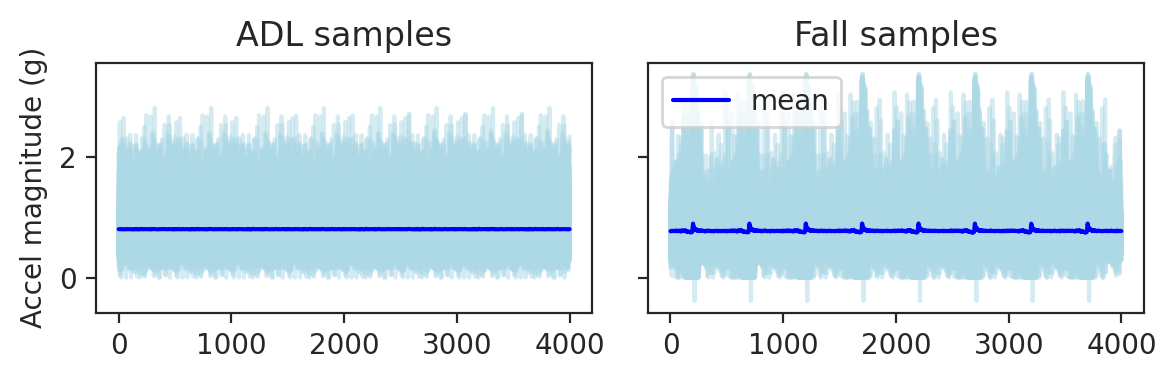

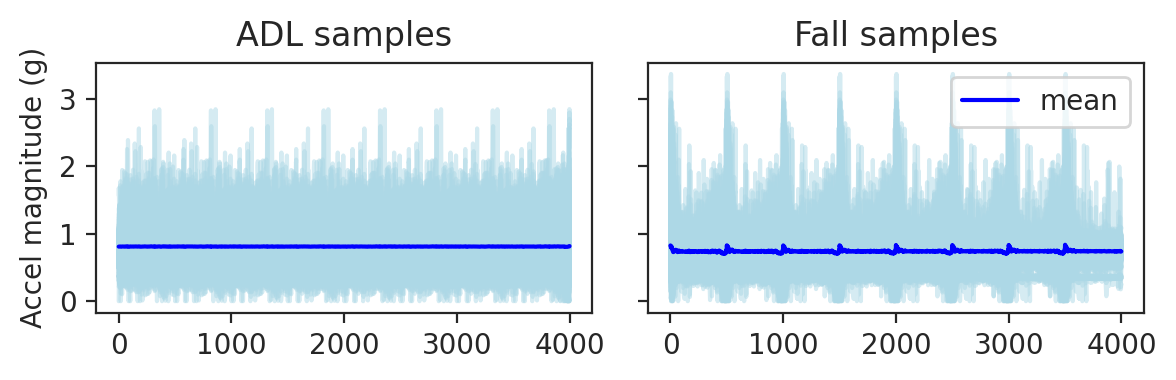

In [3]:
kwargs = dict(window_size=40,
              spacing=5,
              step=5,
              visualize=True)
(
    X_train, X_test, y_train, y_test
) = utils.train_test_subjects_split(
    farseeing, **kwargs)

## Classification with Time Series Models

In [19]:
kwargs = dict(
	window_size=40,
    spacing=5, step=5,
    visualize=True, cv=3,
	model_type='ts'
)

def cross_val():
	cv_df, aggr_df = classifiers.cross_validate(
		farseeing, loaded_df=farseeing_df, **kwargs)
	return cv_df, aggr_df

cv_df = aggr_df = None
if cv_df is None:
	cv_df, aggr_df = cross_val()
else:
	this_cv_df, this_aggr_df = cross_val()
	cv_df = pd.concat([cv_df, this_cv_df], ignore_index=True)



-- fold 1 (13 subjects) --
Train set: X: (2527, 4000), y: (2527,)            ([ADLs, Falls]) [1743  784]
Test set: X: (4093, 4000), y: (4093,)            ([ADLs, Falls]) [3717  376]
Hydra... Rocket... MultiRocketHydra... Catch22... QUANT... 

-- fold 2 (13 subjects) --
Train set: X: (3586, 4000), y: (3586,)            ([ADLs, Falls]) [2650  936]
Test set: X: (1799, 4000), y: (1799,)            ([ADLs, Falls]) [1575  224]
Hydra... Rocket... MultiRocketHydra... Catch22... QUANT... 

-- fold 3 (13 subjects) --
Train set: X: (2579, 4000), y: (2579,)            ([ADLs, Falls]) [1963  616]
Test set: X: (4230, 4000), y: (4230,)            ([ADLs, Falls]) [3686  544]
Hydra... Rocket... MultiRocketHydra... Catch22... QUANT... 

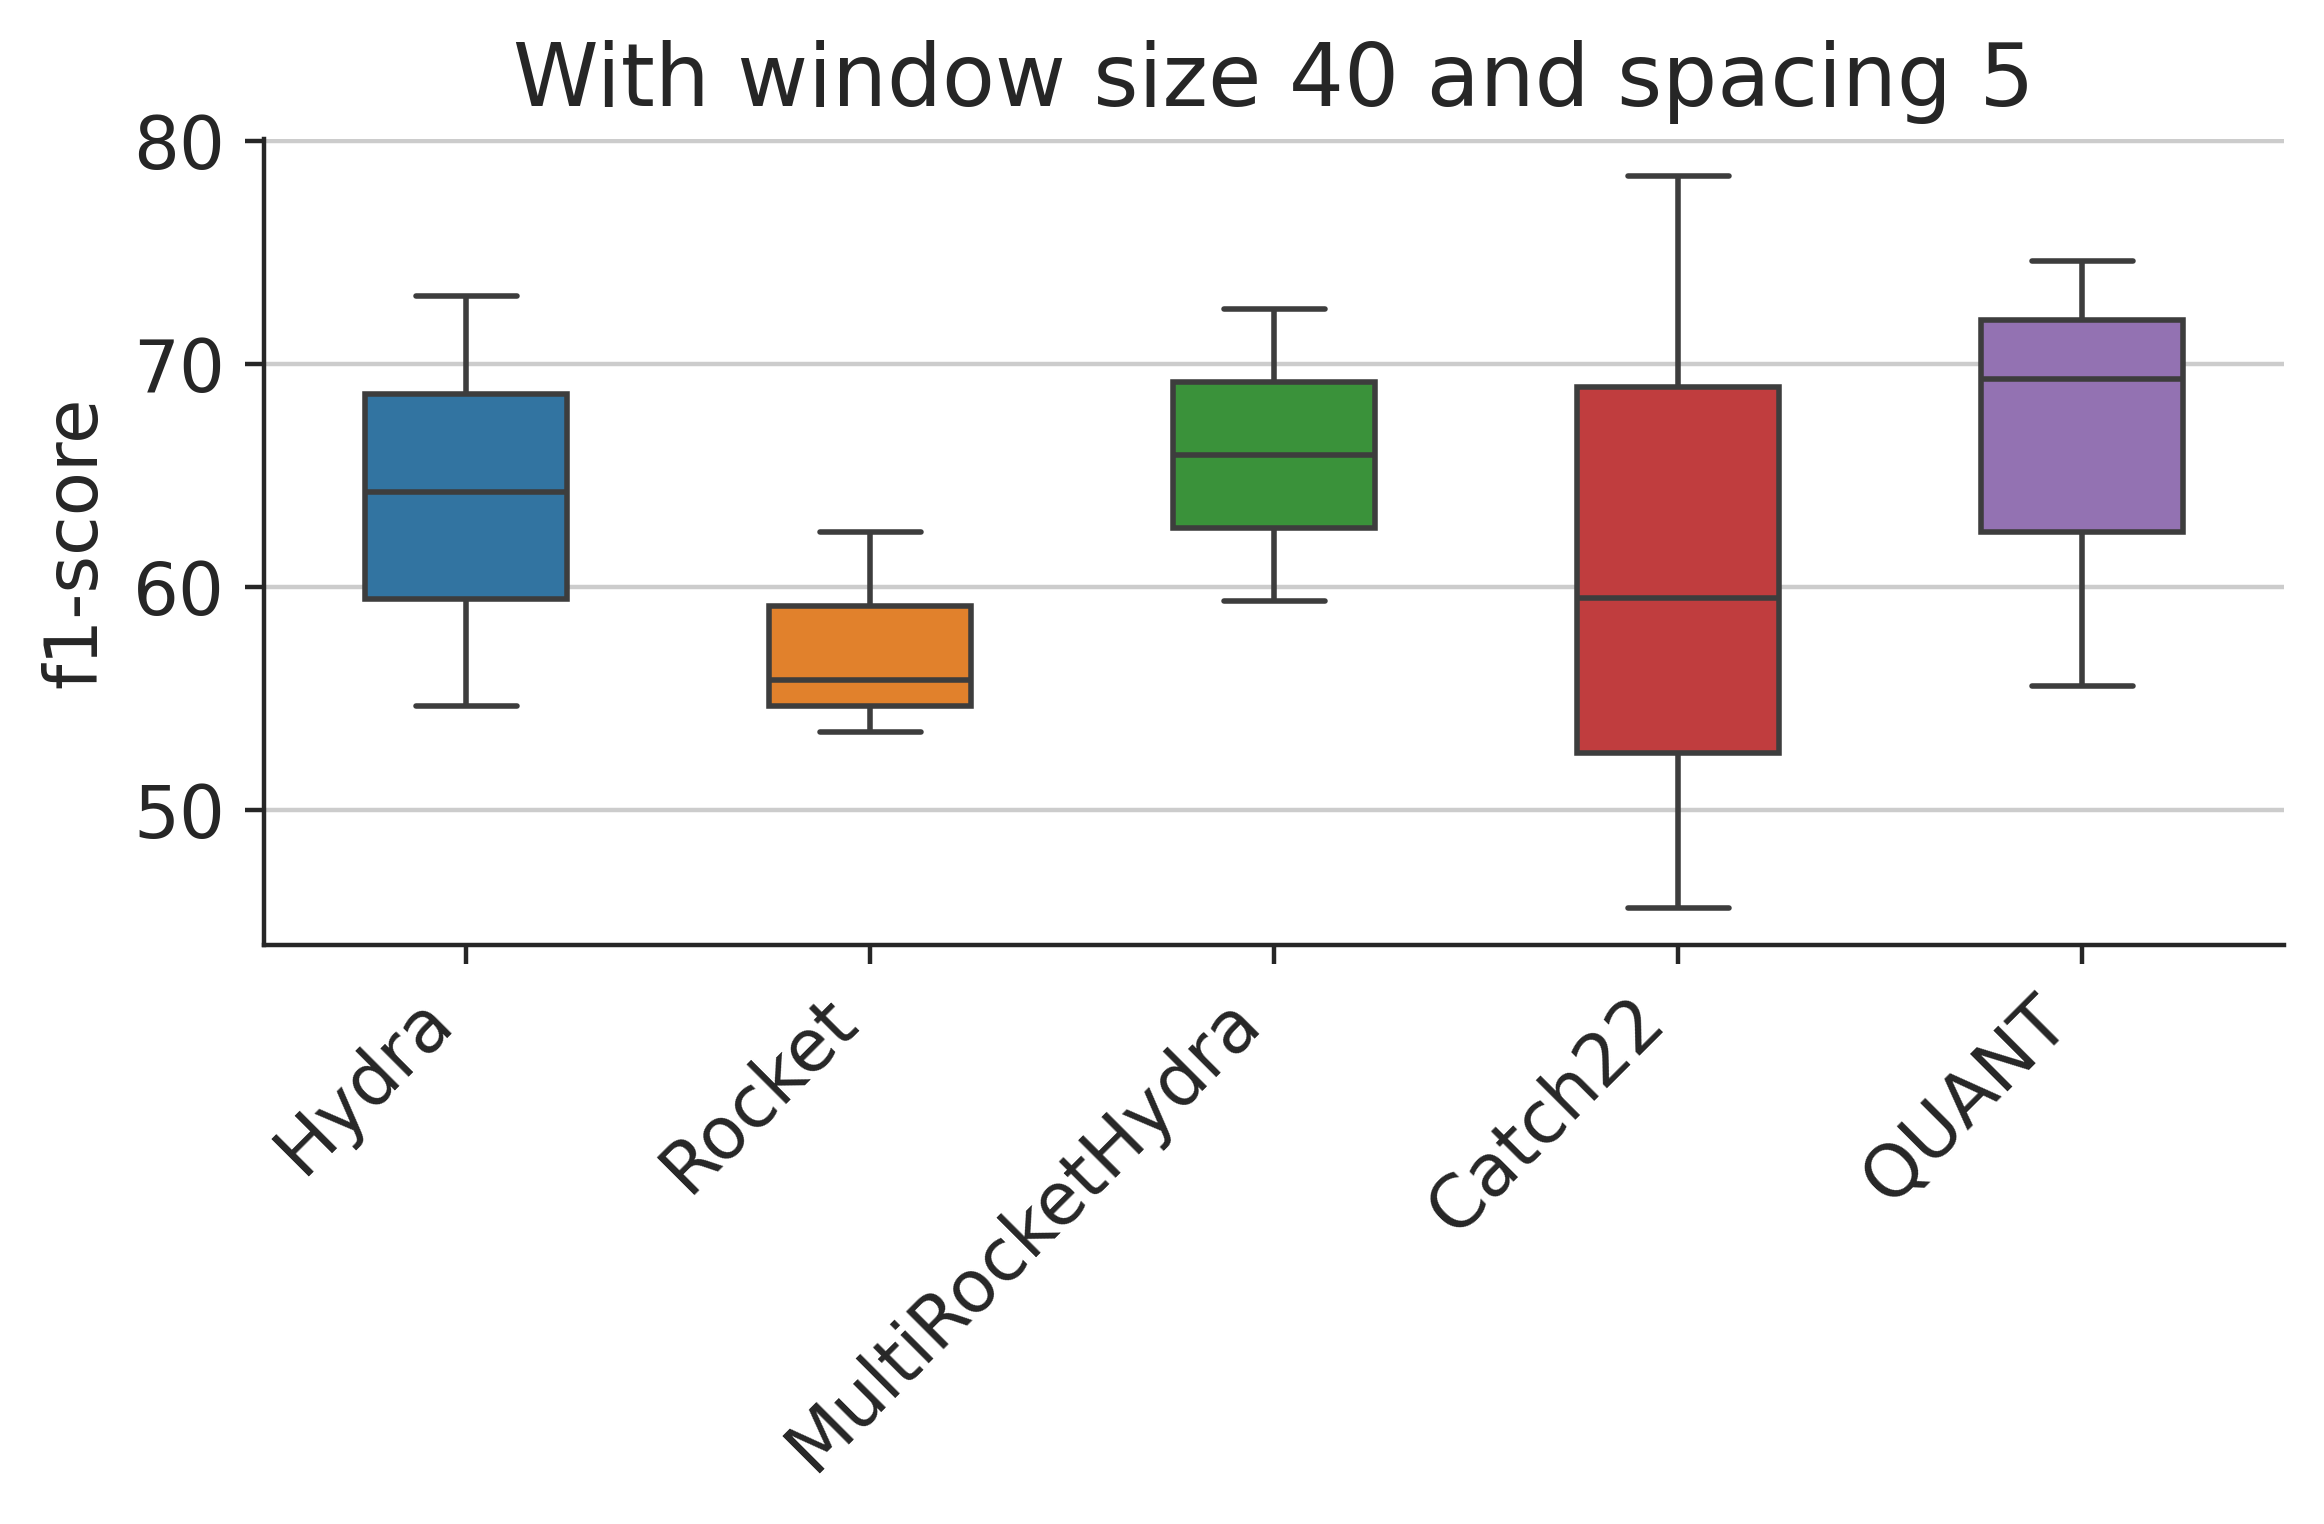

In [21]:
utils.summary_visualization(
    [cv_df], x='model', model_type='ts',
	title='With window size 40 and spacing 5')

In [ ]:
"""
The test set is not segmented,
so the whole signals are used.
y_test contains the fall points
for each signal.
"""

kwargs = dict(window_size=40,
              spacing=5, step=5,
              segment_test=False)
(
    X_train, X_test, y_train, y_test
) = utils.train_test_subjects_split(
    farseeing, **kwargs)

41 subjects
Train set: X: (3243, 4000), y: (3243,)        ([ADLs, Falls]) [2355  888]
Test set: X: 34, y: 34


In [11]:
len(y_test)

34

In [12]:
"""
Train QUANT on the training set and evaluate on the test set
by looping through the test set in a streaming fashion
and getting the predict_proba values for each window.
"""
from aeon.classification.interval_based import QUANTClassifier
quant = QUANTClassifier(random_state=0)
quant.fit(X_train, y_train)

QUANTClassifier(random_state=0)

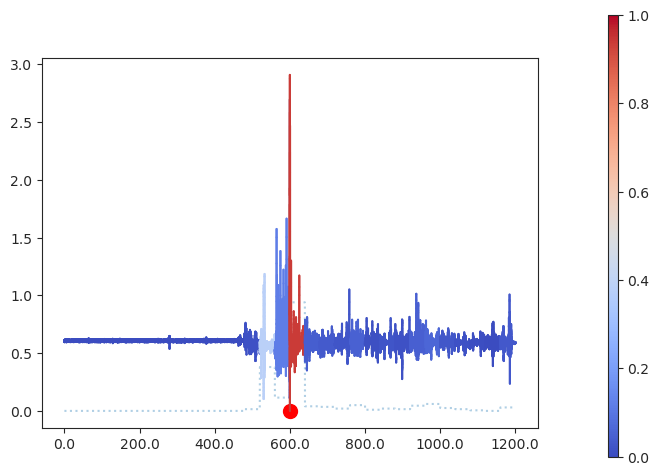

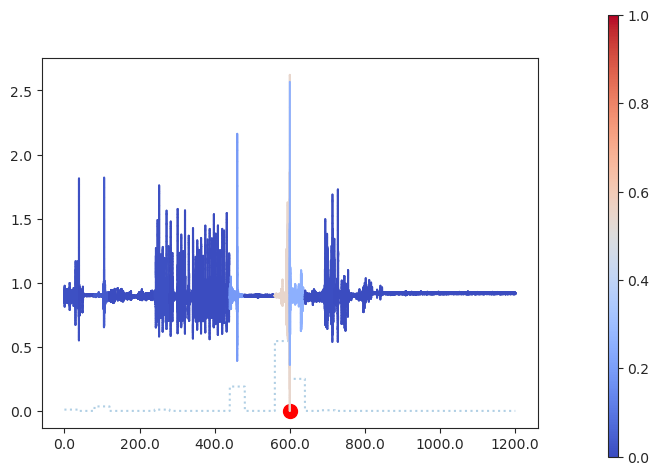

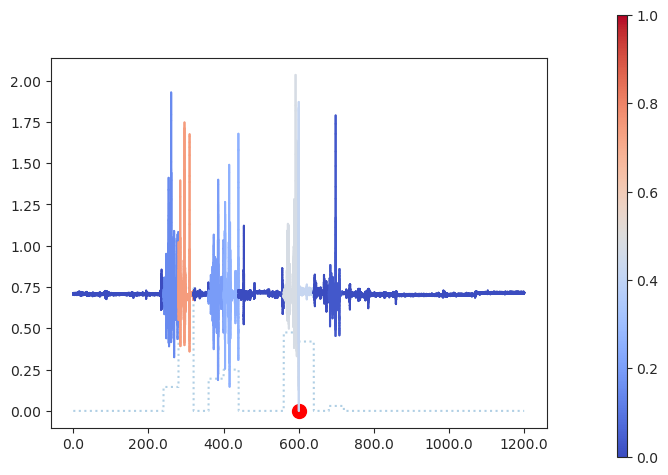

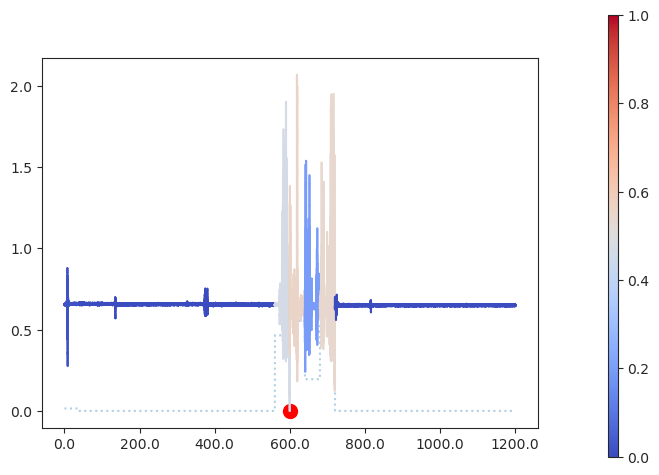

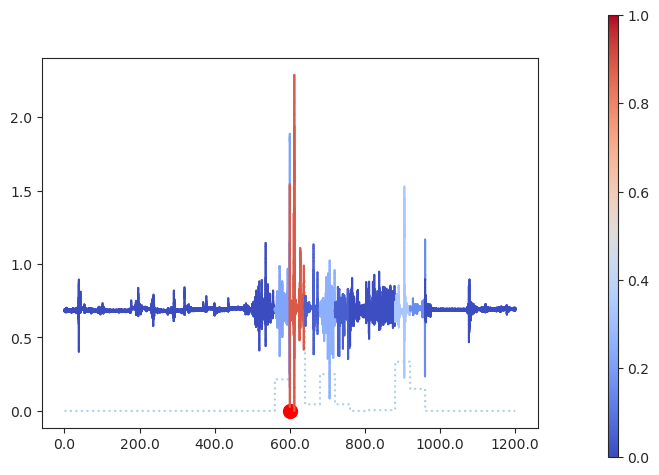

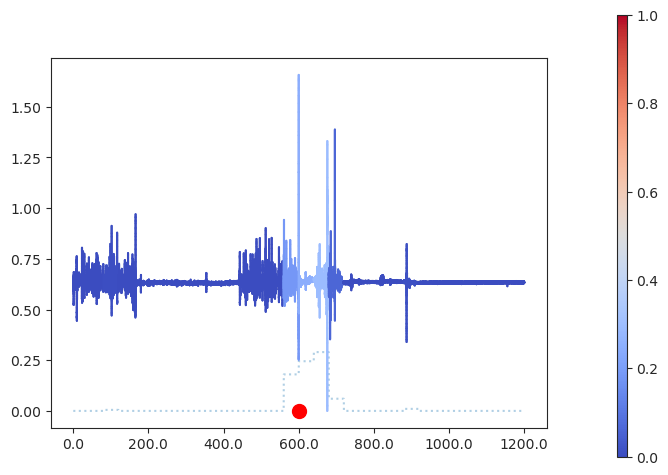

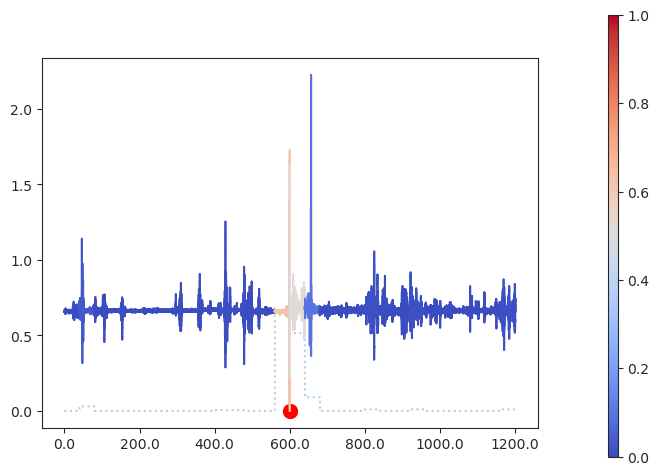

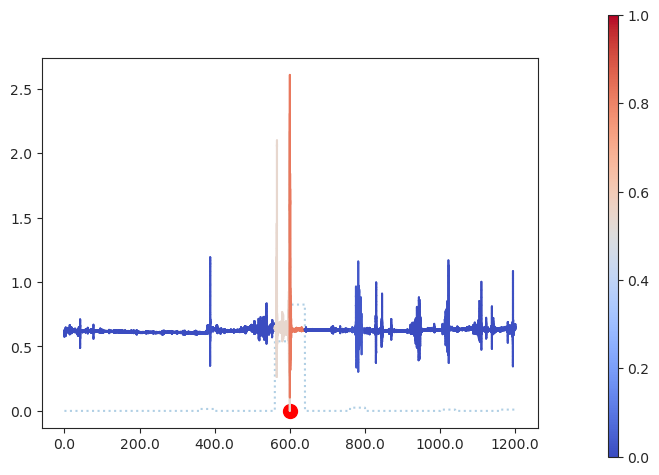

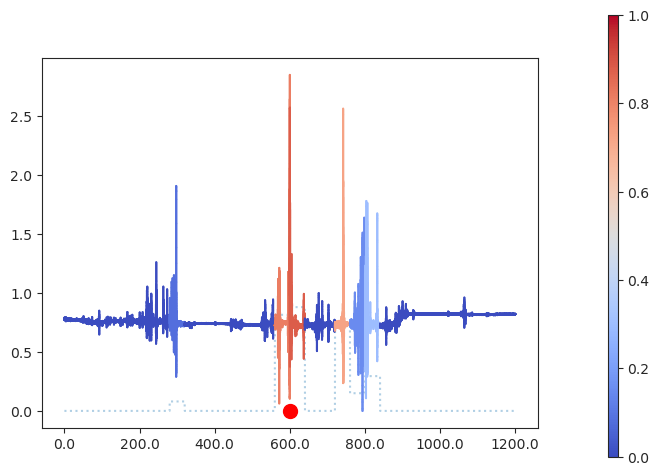

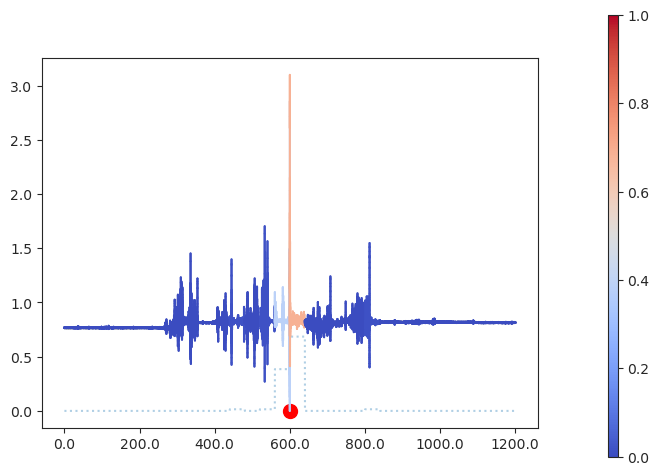

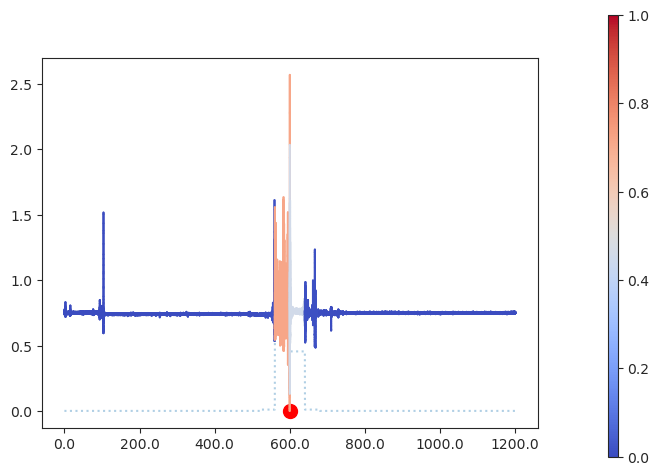

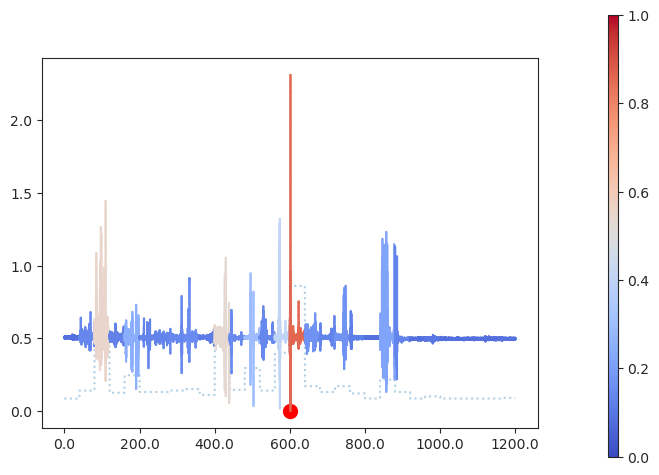

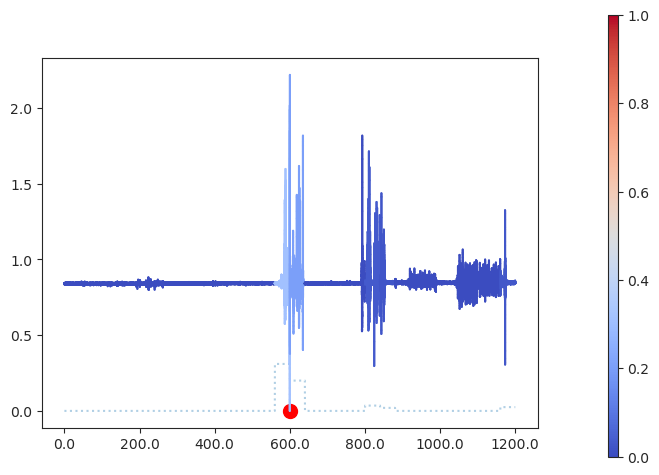

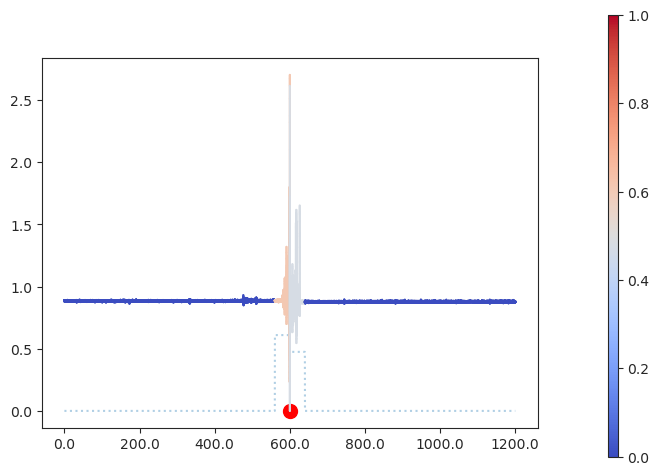

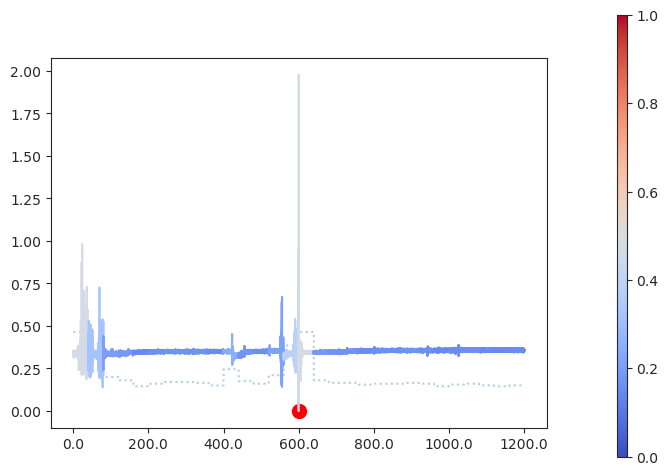

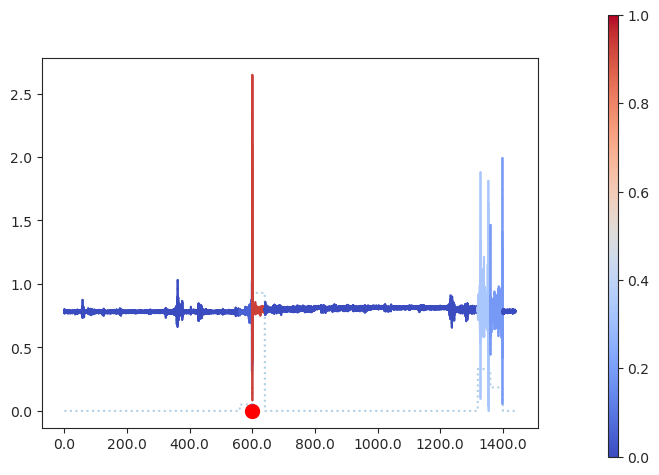

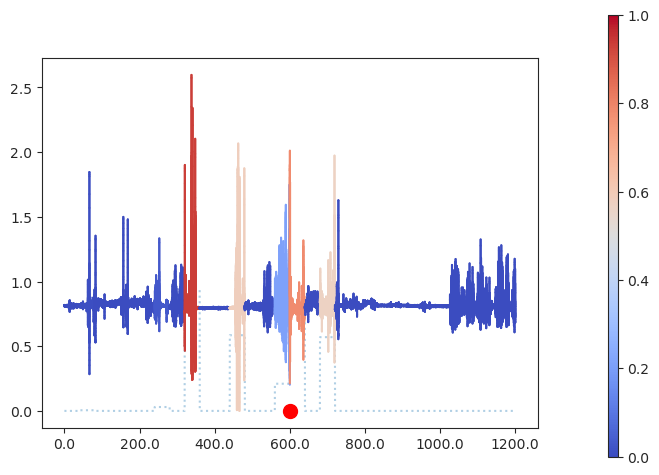

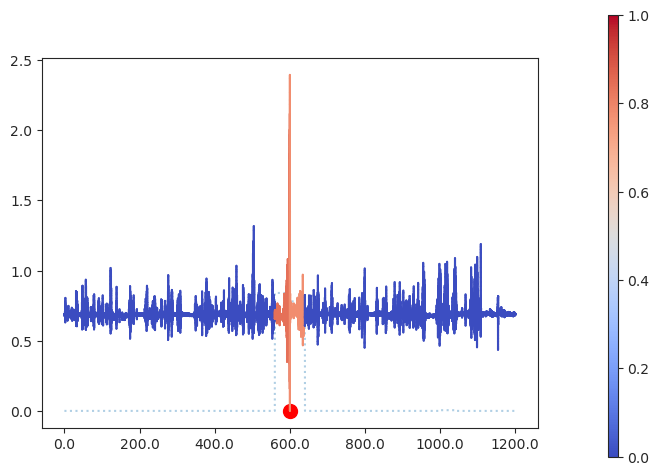

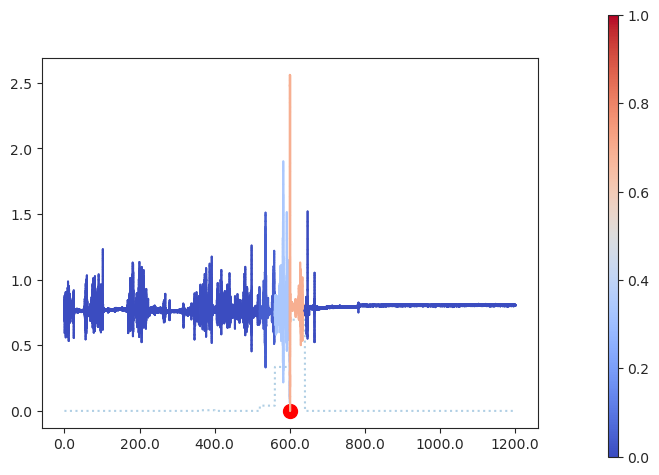

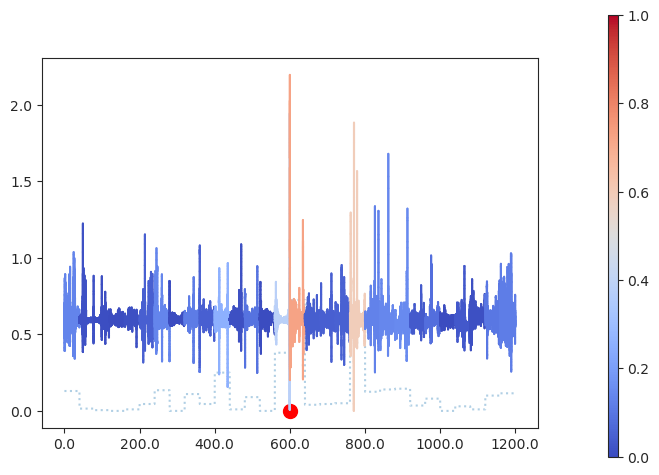

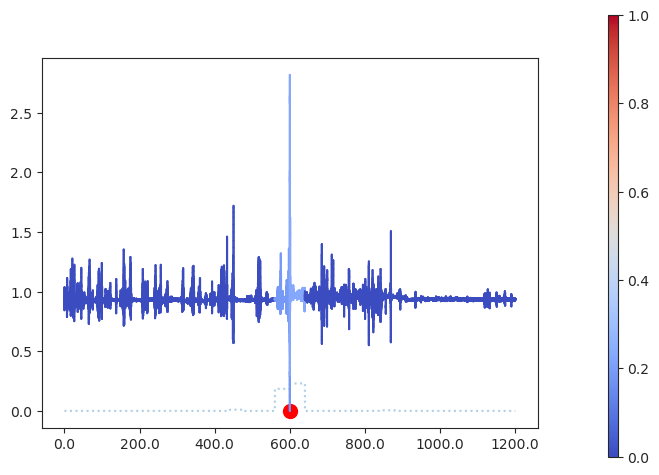

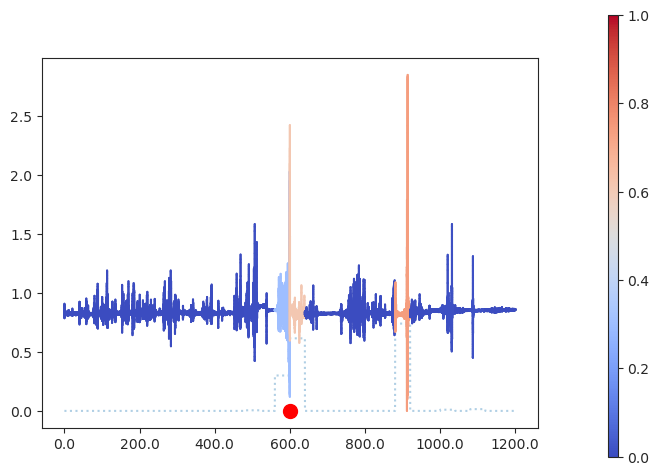

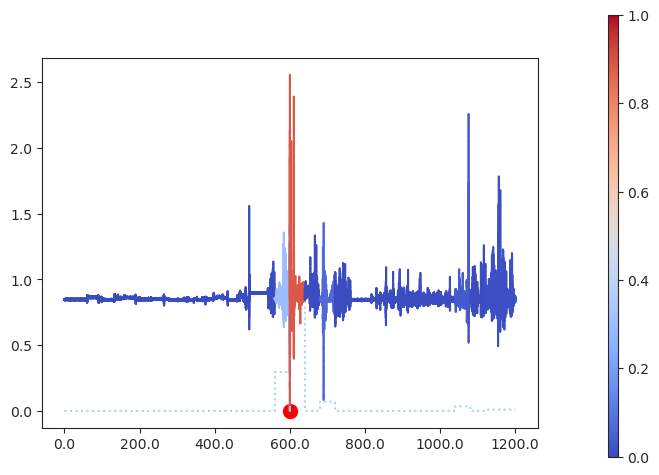

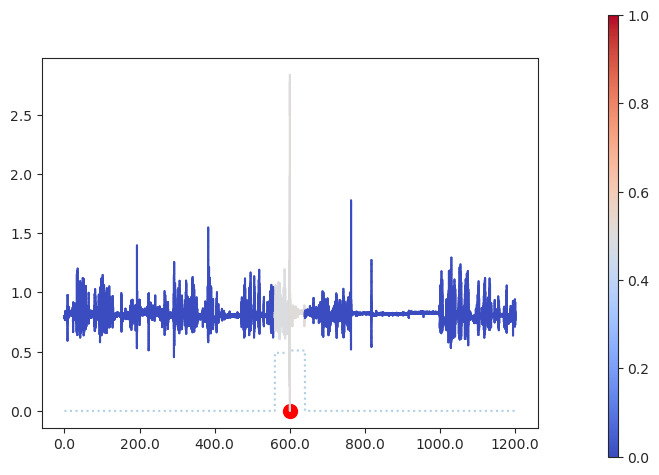

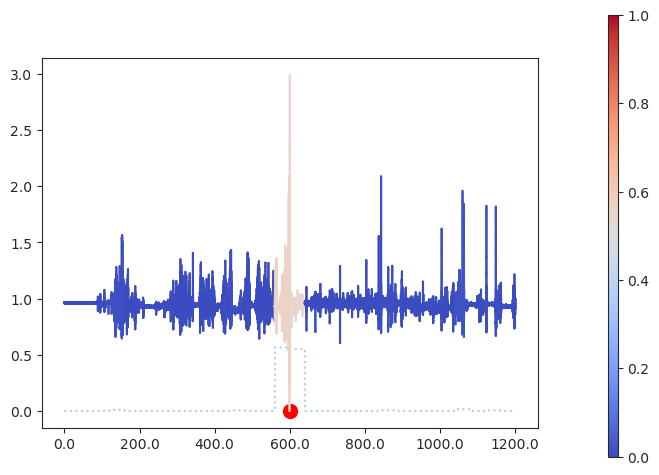

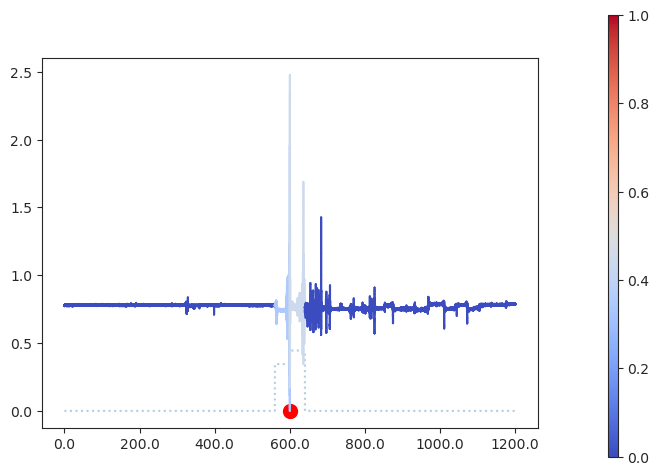

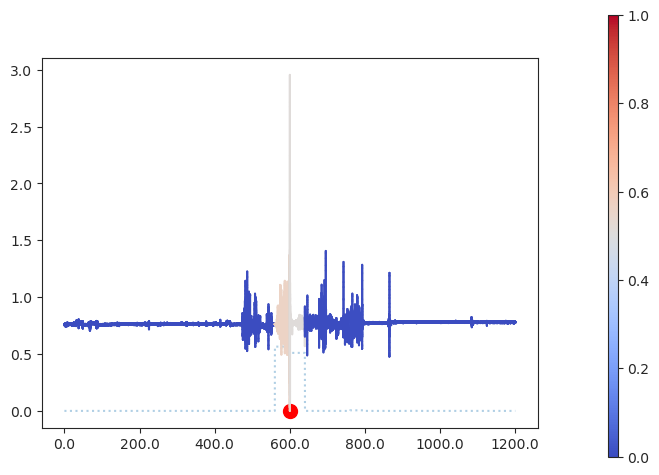

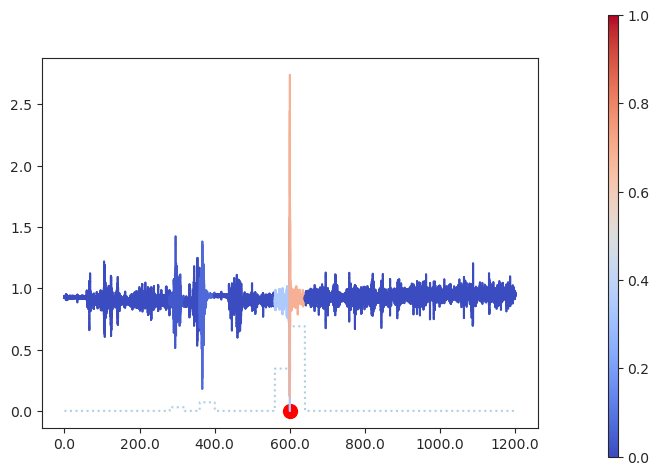

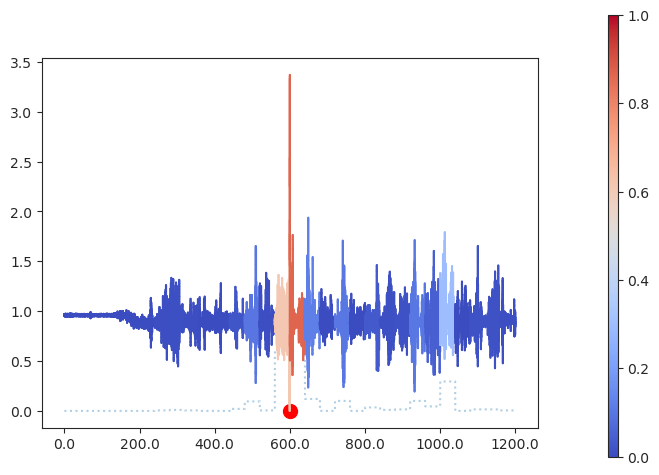

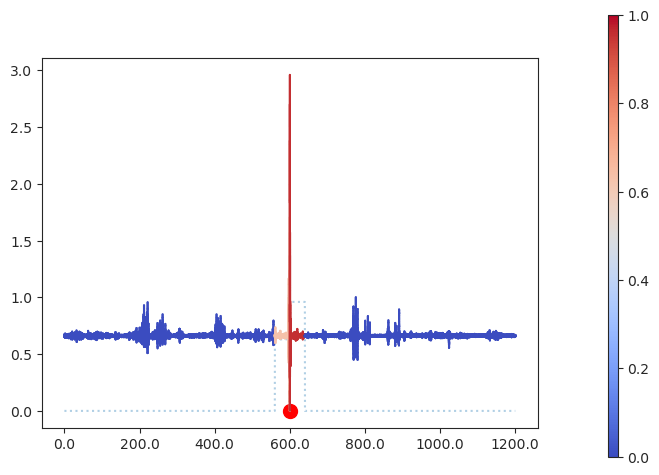

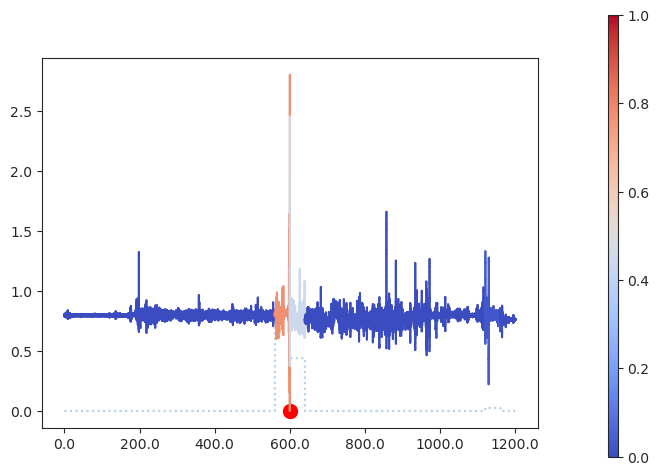

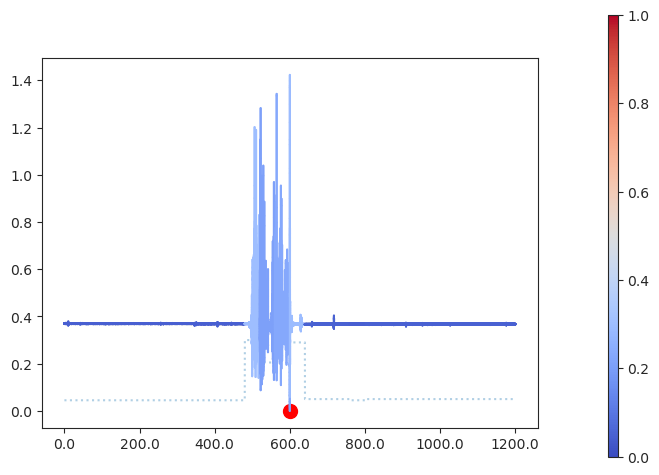

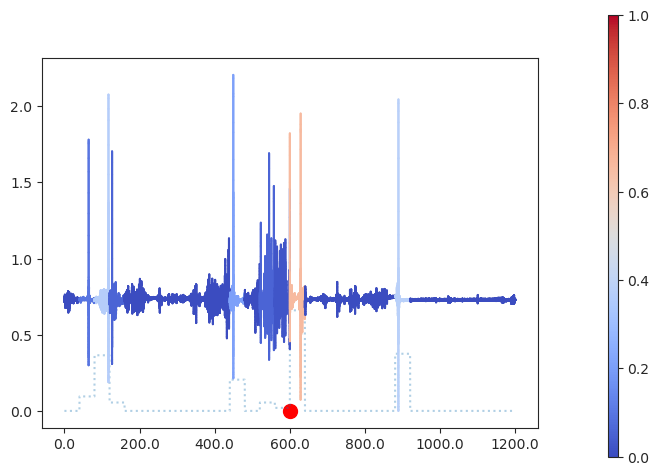

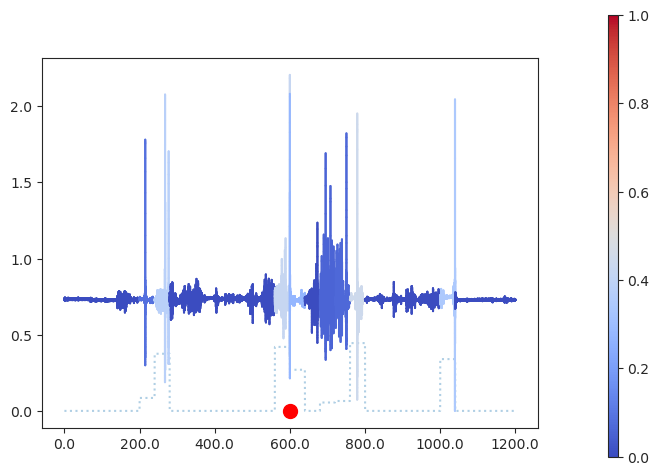

In [13]:
# for each sample in the test set, get the predict_proba values for each window
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

def plot_confidence(ts, c, fall_point):
	cmap = plt.get_cmap('coolwarm')
	x = np.arange(len(ts))
	fig, ax = plt.subplots()
	ax.plot(c, linestyle=':', label='confidence', alpha=0.35)
	# Normalize the color values
	norm = mcolors.Normalize(vmin=0, vmax=1)
	for j in range(len(x)-1):
		x_segment = x[j:j+2]
		ts_segment = ts[j:j+2]
		# print(len(c))
		norms = norm(c[j])
		ax.plot(x_segment, ts_segment, color=cmap(norms), linewidth=1.5)
	ticks_loc = ax.get_xticks().tolist()
	ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
	ax.set_xticklabels([i//100 for i in ticks_loc])
	# ax.grid(which='both', axis='x')     
	# Adding color bar to show the color scale
	sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	cax = plt.axes((1.01, 0.05, 0.015, 0.92))
	plt.colorbar(sm, cax=cax)
	# fig.supxlabel('Time in seconds')
	# sns.despine()
	ax.scatter(fall_point, 0, color='red', s=100, label='Fall point')
	plt.show()

for i in range(0, len(X_test)):
	t = X_test[i]
	probas = []
	for j in range(0, len(t), 4000):
		window = t[j:j+4000]
		if len(window) >= 4000:
			window = np.array(window).reshape(1, -1)
			probs = quant.predict_proba(window)[0][1]
			probas.extend([probs]*4000)
	# plot the whole X_test signal and color the windows according to the predict_proba values
	plot_confidence(t, probas, fall_point=y_test[i])